# YOLO DETECCION DE PERSONAS

In [5]:
import cv2
import numpy as np
import glob

# Cargar los archivos de configuración y pesos
config_path = 'conf.cfg'
weights_path = 'pesos.weights'
names_path = 'obj.names'

# Cargar la lista de nombres de clases
with open(names_path, 'r') as f:
    class_names = [line.strip() for line in f.readlines()]

# Cargar el modelo YOLOv4
net = cv2.dnn.readNetFromDarknet(config_path, weights_path)

# Obtener la lista de capas de salida
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

image_folder = './fotos'
image_files = glob.glob(image_folder + '*.png') + glob.glob(image_folder + '*.jpg')

# Iterar sobre cada imagen
for image_path in image_files:
    # Cargar la imagen de entrada
    image = cv2.imread(image_path)
    height, width, channels = image.shape

    # Preprocesar la imagen para que se ajuste a la entrada del modelo
    blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)

    # Establecer la entrada del modelo
    net.setInput(blob)

    # Ejecutar la detección de objetos
    layer_outputs = net.forward(output_layers)

    # Recopilar información sobre detecciones de personas
    boxes = []
    confidences = []
    class_ids = []

    for output in layer_outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if confidence > 0.5 and class_id == 0:  # Clase 0 es para personas
                # Escalar las coordenadas de la caja delimitadora al tamaño de la imagen original
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                # Calcular las coordenadas de la esquina superior izquierda de la caja delimitadora
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    # Aplicar supresión no máxima para eliminar detecciones superpuestas
    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

    # Encontrar el bounding box de mayor área
    max_area = 0
    max_box = None

    for i in indices:
        i = i[0]
        x, y, w, h = boxes[i]
        area = w * h

        if area > max_area:
            max_area = area
            max_box = (x, y, w, h)

    # Dibujar el bounding box de mayor área en la imagen
    if max_box is not None:
        x, y, w, h = max_box
        label = class_names[class_ids[i]]
        confidence = confidences[i]

        # Dibujar la caja delimitadora y el nombre de la clase
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(image, f'{label}: {confidence:.2f}', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Mostrar la imagen con el bounding box de mayor área
    cv2.imshow('YOLOv4 Detection', image)

    # Esperar la tecla 's' para pasar a la siguiente imagen
    key = cv2.waitKey(0)
    if key == ord('s'):
        continue

    # Cerrar la ventana si se presiona cualquier otra tecla
    break

cv2.destroyAllWindows()


## YOLO PARA RECORTAR (guardo img recortadas)

In [4]:
import cv2
import numpy as np
import glob
import os

# Cargar los archivos de configuración y pesos
config_path = 'conf.cfg'
weights_path = 'pesos.weights'
names_path = 'obj.names'

# Cargar la lista de nombres de clases
with open(names_path, 'r') as f:
    class_names = [line.strip() for line in f.readlines()]

# Cargar el modelo YOLOv4
net = cv2.dnn.readNetFromDarknet(config_path, weights_path)

# Obtener la lista de capas de salida
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# Obtener la lista de archivos de imagen en la carpeta "fotos"
image_folder = './fotos'
image_files = glob.glob(image_folder + '*.png') + glob.glob(image_folder + '*.jpg')

# Iterar sobre cada imagen
for image_path in image_files:
    # Cargar la imagen de entrada
    image = cv2.imread(image_path)
    height, width, channels = image.shape

    # Preprocesar la imagen para que se ajuste a la entrada del modelo
    blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)

    # Establecer la entrada del modelo
    net.setInput(blob)

    # Ejecutar la detección de objetos
    layer_outputs = net.forward(output_layers)

    # Recopilar información sobre detecciones de personas
    boxes = []
    confidences = []
    class_ids = []

    for output in layer_outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if confidence > 0.5 and class_id == 0:  # Clase 0 es para personas
                # Escalar las coordenadas de la caja delimitadora al tamaño de la imagen original
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                # Calcular las coordenadas de la esquina superior izquierda de la caja delimitadora
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    # Si no se encontraron personas, eliminar la imagen y pasar a la siguiente
    if len(boxes) == 0:
        os.remove(image_path)
        continue

    # Obtener el índice de la detección con mayor confianza
    max_confidence_index = np.argmax(confidences)
    x, y, w, h = boxes[max_confidence_index]

    # Recortar la imagen según la ROI
    roi = image[y:y + h, x:x + w]

    # Guardar la imagen recortada
    roi_filename = os.path.splitext(os.path.basename(image_path))[0] + '_roi.jpg'
    cv2.imwrite(roi_filename, roi)

cv2.destroyAllWindows()


## FUNCION YOLO

In [3]:
def det_persona_yolo(image):
    # Convertir la imagen a un arreglo de Numpy
    image = np.array(image)

# Convertir la imagen de BGR (formato de OpenCV) a RGB (formato de PIL)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, channels = image.shape

    # Preprocesar la imagen para que se ajuste a la entrada del modelo
    blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)

    # Establecer la entrada del modelo
    net.setInput(blob)

    # Ejecutar la detección de objetos
    layer_outputs = net.forward(output_layers)

    # Recopilar información sobre detecciones de personas
    boxes = []
    confidences = []
    class_ids = []

    for output in layer_outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if confidence > 0.5 and class_id == 0:  # Clase 0 es para personas
                # Escalar las coordenadas de la caja delimitadora al tamaño de la imagen original
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                # Calcular las coordenadas de la esquina superior izquierda de la caja delimitadora
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
                # Verificar si se encontró alguna persona en la imagen

    # Aplicar supresión no máxima para eliminar detecciones superpuestas
    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

    # Encontrar el bounding box de mayor área
    max_area = 0
    max_box = None

    for i in indices:
        i = i[0]
        x, y, w, h = boxes[i]
        area = w * h

        if area > max_area:
            max_area = area
            max_box = (x, y, w, h)

    # Dibujar el bounding box de mayor área en la imagen
    if max_box is not None:
        x, y, w, h = max_box
        # Verificar que las coordenadas estén dentro de los límites de la imagen
        x = max(0, x)
        y = max(0, y)
        w = min(w, width - x)
        h = min(h, height - y)
        label = class_names[class_ids[i]]
        confidence = confidences[i]
        if w > 0 and h > 0:
            roi = image[y:y + h, x:x + w]
            roi = Image.fromarray(roi)
            return roi

    # Si no se encontró ninguna ROI válida, retornar None
    return None

# RESNET50 PARA IMAGEN COMPLETA

0354.jpg 14.609582901000977
0033.jpg 14.789596557617188
0675.jpg 15.0630521774292
0185.jpg 15.397294044494629
1060.jpg 15.413464546203613


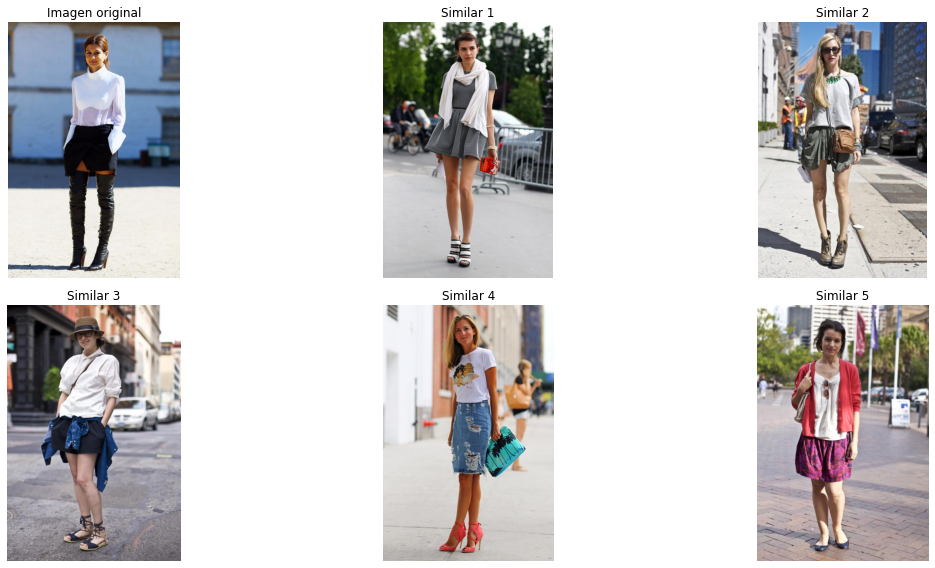

In [62]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image

import os

# Cargar modelo pre-entrenado ResNet50
resnet = models.resnet50(pretrained=True)
modules = list(resnet.children())[:-1]
resnet = torch.nn.Sequential(*modules)
resnet.eval()
img_path = '0012.jpg'
img = Image.open(img_path)

# Transformar imagen para que sea compatible con el modelo ResNet50
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
img_tensor = transform(img)
img_tensor = img_tensor.unsqueeze(0)

with torch.no_grad():
    features = resnet(img_tensor)
# Ruta de la carpeta que contiene las imágenes de referencia
folder_path = 'fotos/'

# Lista para almacenar las distancias y nombres de archivo
distances = []
file_names = []

# Recorrer las imágenes en la carpeta
for file_name in os.listdir(folder_path):
    # Cargar la imagen
    img_path = os.path.join(folder_path, file_name)
    img = Image.open(img_path)

    # Transformar la imagen
    img_tensor = transform(img)
    img_tensor = img_tensor.unsqueeze(0)

    # Calcular características
    with torch.no_grad():
        features_other = resnet(img_tensor)

    # Calcular distancia euclidiana entre las características
    distance = torch.norm(features - features_other)

    # Agregar distancia y nombre de archivo a las listas
    distances.append(distance.item())
    file_names.append(file_name)
# Ordenar las imágenes por distancia (de menor a mayor)
sorted_images = sorted(zip(file_names, distances), key=lambda x: x[1])

# Obtener las imágenes más similares (las primeras K imágenes)
K = 5  # Número de imágenes más similares a obtener
similar_images = sorted_images[:K]

# Imprimir las imágenes más similares
for image, distance in similar_images:
    print(image, distance)

import matplotlib.pyplot as plt

# Cargar y mostrar la imagen original
img_path = '0012.jpg'
original_image = Image.open(img_path)
plt.figure(figsize=(18, 8))
plt.subplot(2, 3, 1)
plt.imshow(original_image)
plt.title("Imagen original")
plt.axis("off")

# Mostrar las 5 imágenes más similares
for i, (image_name, distance) in enumerate(similar_images):
    image_path = os.path.join(folder_path, image_name)
    similar_image = Image.open(image_path)
    plt.subplot(2, 3, i + 2)
    plt.imshow(similar_image)
    plt.title(f"Similar {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

# INCEPTION PARA IMAGEN COMPLETA

1934.jpg 29.697032928466797
0348.jpg 30.365825653076172
0663.jpg 30.420621871948242
0717.jpg 30.494571685791016
1113.jpg 30.618133544921875


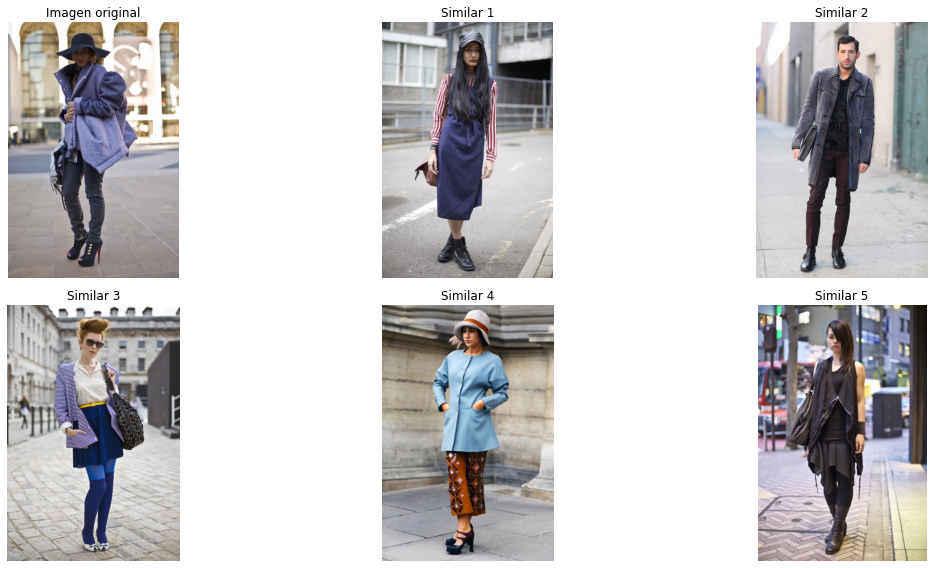

In [87]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image

import os

# Cargar modelo pre-entrenado InceptionV3
inception = models.inception_v3(pretrained=True)
inception.eval()

img_path = '0016.jpg'
img = Image.open(img_path).convert('RGB')

# Transformar imagen para que sea compatible con el modelo InceptionV3
preprocess = transforms.Compose([
    transforms.Resize((299, 299)),  # Tamaño de entrada esperado por InceptionV3
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
img_tensor = preprocess(img).unsqueeze(0)

with torch.no_grad():
    # Obtener las características de la imagen
    features = inception(img_tensor)

# Ruta de la carpeta que contiene las imágenes de referencia
folder_path = 'fotos/'

# Lista para almacenar las distancias y nombres de archivo
distances = []
file_names = []

# Recorrer las imágenes en la carpeta
for file_name in os.listdir(folder_path):
    # Cargar la imagen
    img_path = os.path.join(folder_path, file_name)
    img = Image.open(img_path).convert('RGB')

    # Transformar la imagen
    img_tensor = preprocess(img).unsqueeze(0)

    with torch.no_grad():
        # Obtener las características de la imagen de referencia
        features_other = inception(img_tensor)

    # Calcular distancia euclidiana entre las características
    distance = torch.norm(features - features_other)

    # Agregar distancia y nombre de archivo a las listas
    distances.append(distance.item())
    file_names.append(file_name)

# Ordenar las imágenes por distancia (de menor a mayor)
sorted_images = sorted(zip(file_names, distances), key=lambda x: x[1])

# Obtener las imágenes más similares (las primeras K imágenes)
K = 5  # Número de imágenes más similares a obtener
similar_images = sorted_images[:K]

# Imprimir las imágenes más similares
for image, distance in similar_images:
    print(image, distance)

import matplotlib.pyplot as plt

# Cargar y mostrar la imagen original
img_path = '0016.jpg'
original_image = Image.open(img_path)
plt.figure(figsize=(18, 8))
plt.subplot(2, 3, 1)
plt.imshow(original_image)
plt.title("Imagen original")
plt.axis("off")

# Mostrar las 5 imágenes más similares
for i, (image_name, distance) in enumerate(similar_images):
    image_path = os.path.join(folder_path, image_name)
    similar_image = Image.open(image_path)
    plt.subplot(2, 3, i + 2)
    plt.imshow(similar_image)
    plt.title(f"Similar {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()


## VGG

0670.jpg 177.471923828125
0172.jpg 183.84422302246094
0788.jpg 184.57569885253906
0796.jpg 184.94412231445312
0046.jpg 185.52127075195312


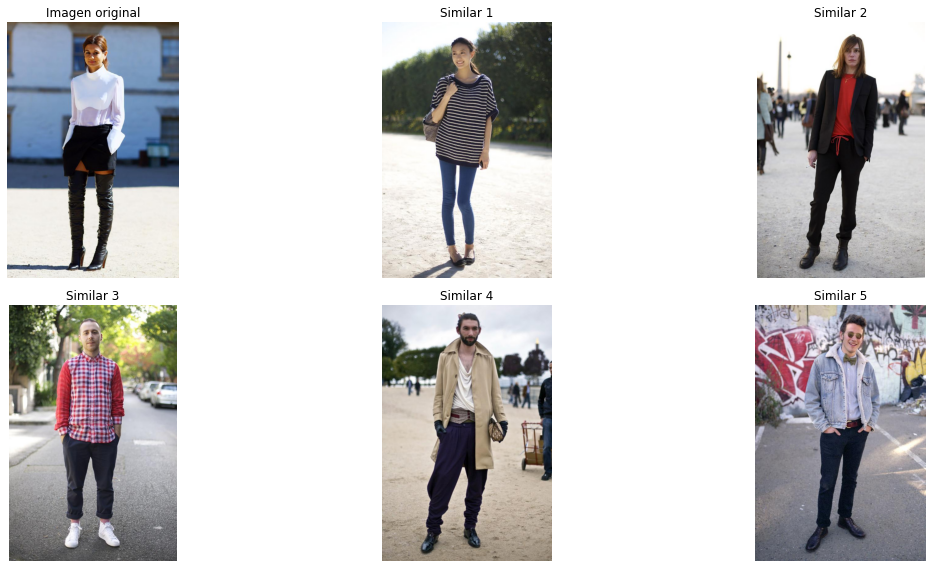

In [38]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image

import os

# Cargar modelo pre-entrenado VGG19
vgg = models.vgg19(pretrained=True)
modules = list(vgg.features.children())[:-1]
vgg = torch.nn.Sequential(*modules)
vgg.eval()

img_path = '0012.jpg'
img = Image.open(img_path)
#img = det_persona_yolo(img)
# Transformar imagen para que sea compatible con el modelo VGG16
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Tamaño de entrada esperado por VGG16
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
img_tensor = transform(img)
img_tensor = img_tensor.unsqueeze(0)

with torch.no_grad():
    features = vgg(img_tensor)
    
# Ruta de la carpeta que contiene las imágenes de referencia
folder_path = 'fotos/'

# Lista para almacenar las distancias y nombres de archivo
distances = []
file_names = []

# Recorrer las imágenes en la carpeta
for file_name in os.listdir(folder_path):
    # Cargar la imagen
    img_path = os.path.join(folder_path, file_name)
    img = Image.open(img_path)
    #img=det_persona_yolo(img)
    # Transformar la imagen
    if img is None:
        continue  # Saltar al siguiente ciclo si la ROI es None
    # Transformar la imagen
    img_tensor = transform(img)
    img_tensor = img_tensor.unsqueeze(0)

    # Calcular características
    with torch.no_grad():
        features_other = vgg(img_tensor)

    # Calcular distancia euclidiana entre las características
    distance = torch.norm(features - features_other)

    # Agregar distancia y nombre de archivo a las listas
    distances.append(distance.item())
    file_names.append(file_name)

# Ordenar las imágenes por distancia (de menor a mayor)
sorted_images = sorted(zip(file_names, distances), key=lambda x: x[1])

# Obtener las imágenes más similares (las primeras K imágenes)
K = 5  # Número de imágenes más similares a obtener
similar_images = sorted_images[:K]

# Imprimir las imágenes más similares
for image, distance in similar_images:
    print(image, distance)

import matplotlib.pyplot as plt

# Cargar y mostrar la imagen original
img_path = '0012.jpg'
original_image = Image.open(img_path)
plt.figure(figsize=(18, 8))
plt.subplot(2, 3, 1)
plt.imshow(original_image)
plt.title("Imagen original")
plt.axis("off")

# Mostrar las 5 imágenes más similares
for i, (image_name, distance) in enumerate(similar_images):
    image_path = os.path.join(folder_path, image_name)
    similar_image = Image.open(image_path)
    plt.subplot(2, 3, i + 2)
    plt.imshow(similar_image)
    plt.title(f"Similar {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()


# DenseNet imagen completa

0721.jpg 15.839393615722656
0817.jpg 15.917126655578613
0006.jpg 16.218538284301758
0685.jpg 16.34500503540039
0124.jpg 16.423568725585938


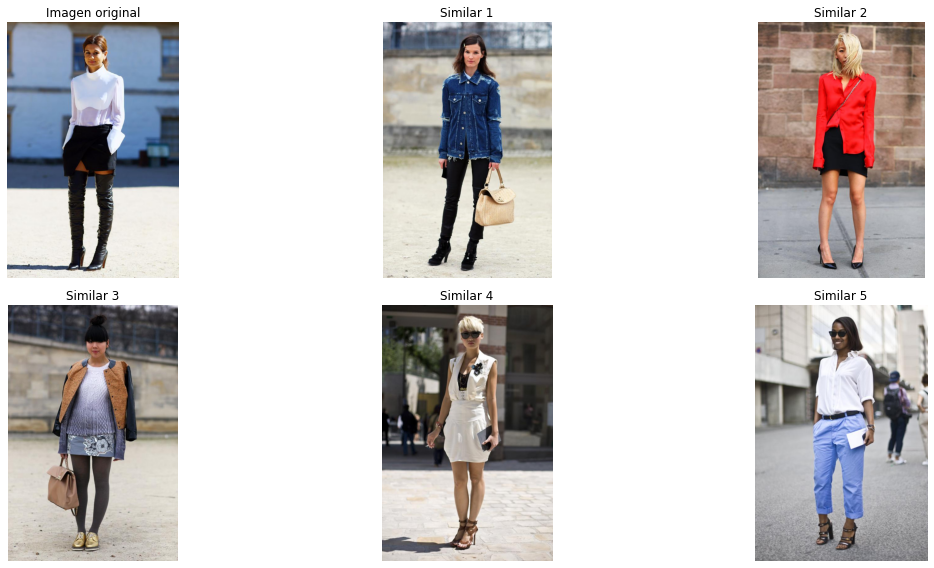

In [34]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image

import os

# Cargar modelo pre-entrenado DenseNet121
densenet = models.densenet121(pretrained=True)
modules = list(densenet.features.children())[:-1]
densenet = torch.nn.Sequential(*modules)
densenet.eval()

img_path = '0012.jpg'
img = Image.open(img_path)
#img = det_persona_yolo(img)
# Transformar imagen para que sea compatible con el modelo DenseNet121
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Tamaño de entrada esperado por DenseNet121
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
img_tensor = transform(img)
img_tensor = img_tensor.unsqueeze(0)

with torch.no_grad():
    features = densenet(img_tensor)

# Ruta de la carpeta que contiene las imágenes de referencia
folder_path = 'fotos/'

# Lista para almacenar las distancias y nombres de archivo
distances = []
file_names = []

# Recorrer las imágenes en la carpeta
for file_name in os.listdir(folder_path):
    # Cargar la imagen
    img_path = os.path.join(folder_path, file_name)
    img = Image.open(img_path)
    #img=det_persona_yolo(img)
    # Transformar la imagen
    if img is None:
        continue  # Saltar al siguiente ciclo si la ROI es None
    # Transformar la imagen
    img_tensor = transform(img)
    img_tensor = img_tensor.unsqueeze(0)

    # Calcular características
    with torch.no_grad():
        features_other = densenet(img_tensor)

    # Calcular distancia euclidiana entre las características
    distance = torch.norm(features - features_other)

    # Agregar distancia y nombre de archivo a las listas
    distances.append(distance.item())
    file_names.append(file_name)

# Ordenar las imágenes por distancia (de menor a mayor)
sorted_images = sorted(zip(file_names, distances), key=lambda x: x[1])

# Obtener las imágenes más similares (las primeras K imágenes)
K = 5  # Número de imágenes más similares a obtener
similar_images = sorted_images[:K]

# Imprimir las imágenes más similares
for image, distance in similar_images:
    print(image, distance)

import matplotlib.pyplot as plt

# Cargar y mostrar la imagen original
img_path = '0012.jpg'
original_image = Image.open(img_path)
plt.figure(figsize=(18, 8))
plt.subplot(2, 3, 1)
plt.imshow(original_image)
plt.title("Imagen original")
plt.axis("off")

# Mostrar las 5 imágenes más similares
for i, (image_name, distance) in enumerate(similar_images):
    image_path = os.path.join(folder_path, image_name)
    similar_image = Image.open(image_path)
    plt.subplot(2, 3, i + 2)
    plt.imshow(similar_image)
    plt.title(f"Similar {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()


## DenseNet ROI

Imagen: 1901.jpg, Distancia: 365.5445556640625
Imagen: 0652.jpg, Distancia: 365.9627685546875
Imagen: 0006.jpg, Distancia: 367.0592041015625
Imagen: 0685.jpg, Distancia: 368.1006164550781
Imagen: 0375.jpg, Distancia: 368.2094421386719


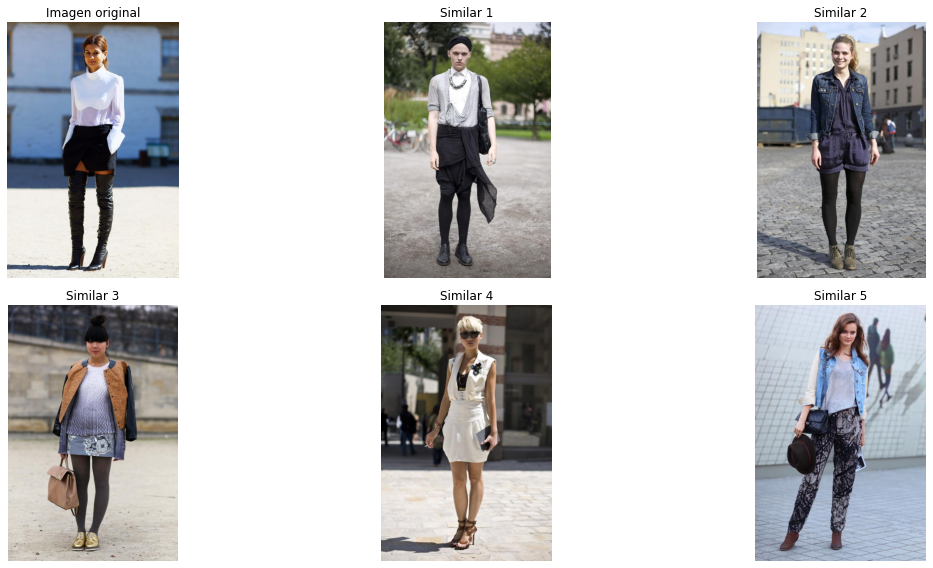

In [35]:
import torch
import torchvision.transforms as transforms
from torchvision.models import densenet121
import os
import numpy as np
from PIL import Image

# Cargar el modelo DenseNet pre-entrenado
model = densenet121(pretrained=True)
model = model.features

# Transformaciones de imagen para el modelo DenseNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Función para extraer características de una imagen
def extract_features(image_path):
    image = transform(Image.open(image_path)).unsqueeze(0)
    image=det_persona_yolo(image)
    # Transformar la imagen
    if image is None:
        return None  #
    features = model(image)
    features = features.view(features.size(0), -1)
    features = features.detach().numpy().flatten()
    return features

# Ruta de la imagen plantilla
template_image_path = "0012.jpg"

# Extraer características de la imagen plantilla
template_features = extract_features(template_image_path)

# Carpeta con las imágenes a comparar
folder_path = "./fotos"

# Obtener la lista de archivos en la carpeta
files = os.listdir(folder_path)

# Diccionario para almacenar las distancias entre imágenes y la imagen plantilla
distances = {}

# Calcular la distancia entre las imágenes y la imagen plantilla
for file in files:
    if file.endswith(".jpg") or file.endswith(".png"):
        file_path = os.path.join(folder_path, file)
        features = extract_features(file_path)
        if features is None:
            continue
        distance = np.linalg.norm(template_features - features)
        distances[file] = distance

# Ordenar las imágenes por distancia y obtener las 5 más similares
sorted_distances = sorted(distances.items(), key=lambda x: x[1])
most_similar_images = sorted_distances[:5]

# Mostrar las imágenes más similares
for image, distance in most_similar_images:
    image_path = os.path.join(folder_path, image)
    img = Image.open(image_path)
    img.show()
    print(f"Imagen: {image}, Distancia: {distance}")

import matplotlib.pyplot as plt

# Cargar y mostrar la imagen original
img_path = '0012.jpg'
original_image = Image.open(img_path)
plt.figure(figsize=(18, 8))
plt.subplot(2, 3, 1)
plt.imshow(original_image)
plt.title("Imagen original")
plt.axis("off")

# Mostrar las 5 imágenes más similares
for i, (image_name, distance) in enumerate(most_similar_images):
    image_path = os.path.join(folder_path, image_name)
    similar_image = Image.open(image_path)
    plt.subplot(2, 3, i + 2)
    plt.imshow(similar_image)
    plt.title(f"Similar {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()


# RESNET 50

0317.jpg 10.825519561767578
0492.jpg 11.04538631439209
0916.jpg 11.143839836120605
2001.jpg 11.154718399047852
0709.jpg 11.335297584533691


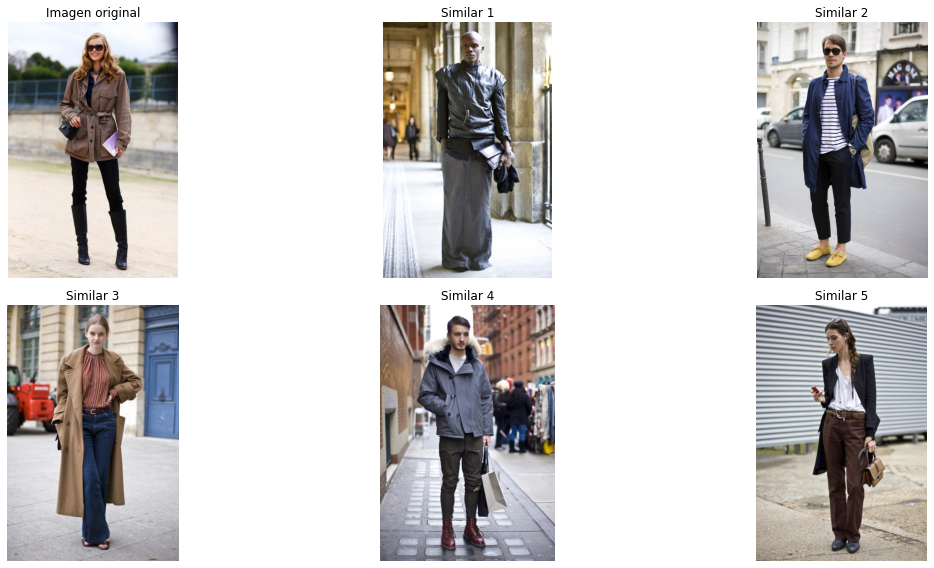

In [30]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image

import os

# Cargar modelo pre-entrenado ResNet50
resnet = models.resnet50(pretrained=True)
modules = list(resnet.children())[:-1]
resnet = torch.nn.Sequential(*modules)
resnet.eval()

img_path = '0003.jpg'
img = Image.open(img_path)
img=det_persona_yolo(img)
# Transformar imagen para que sea compatible con el modelo ResNet50
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
img_tensor = transform(img)
img_tensor = img_tensor.unsqueeze(0)

with torch.no_grad():
    features = resnet(img_tensor)
# Ruta de la carpeta que contiene las imágenes de referencia
folder_path = 'fotos/'

# Lista para almacenar las distancias y nombres de archivo
distances = []
file_names = []

# Recorrer las imágenes en la carpeta
for file_name in os.listdir(folder_path):
    # Cargar la imagen
    
    img_path = os.path.join(folder_path, file_name)
     
    img = Image.open(img_path)
    roi = det_persona_yolo(img)
    if roi is None:
        continue  # Saltar al siguiente ciclo si la ROI es None
    
    # Transformar la imagen
    img_tensor = transform(roi)
    img_tensor = img_tensor.unsqueeze(0)

    # Calcular características
    with torch.no_grad():
        features_other = resnet(img_tensor)

    # Calcular distancia euclidiana entre las características
    distance = torch.norm(features - features_other)

    # Agregar distancia y nombre de archivo a las listas
    distances.append(distance.item())
    file_names.append(file_name)
# Ordenar las imágenes por distancia (de menor a mayor)
sorted_images = sorted(zip(file_names, distances), key=lambda x: x[1])

# Obtener las imágenes más similares (las primeras K imágenes)
K = 5  # Número de imágenes más similares a obtener
similar_images = sorted_images[:K]

# Imprimir las imágenes más similares
for image, distance in similar_images:
    print(image, distance)

import matplotlib.pyplot as plt

# Cargar y mostrar la imagen original
img_path = '0003.jpg'
original_image = Image.open(img_path)

plt.figure(figsize=(18, 8))
plt.subplot(2, 3, 1)
plt.imshow(original_image)
plt.title("Imagen original")
plt.axis("off")

# Mostrar las 5 imágenes más similares
for i, (image_name, distance) in enumerate(similar_images):
    image_path = os.path.join(folder_path, image_name)
    similar_image = Image.open(image_path)
    plt.subplot(2, 3, i + 2)
    plt.imshow(similar_image)
    plt.title(f"Similar {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()